In [1]:
from my_functions import *

from scipy.optimize import curve_fit

orbits fs = 0.05 Hz, orbits t0 = 12160.0 s,  orbit_duration = 1424.0 d
Number of Verification Binaries = 16


In [2]:
N1 = 1

d,dr = -1, dur_range[-1]
alph = 1

fp1 = 'measurements/tm_asds/{}d/{}/fs0.txt'.format(dr,alph)
fp2 = 'plots/{}d/'.format(dr)



In [3]:
# Generate the Galactic binaries
sample_outputf = 'measurements/fitting_test'
gennew = True
discard=300

if gennew:
    GenerateGalbins(orbit_path,gw_path,fs,size[d],Amp_true, f_true, phi0_true_forinst, gw_beta_true,\
                    gw_lambda_true, iota_true,orbits_t0 + 1/fs)


    # Generate the instrument data
    # sAfunc, sEfunc, sTfunc = GenerateInstrumentAET(orbit_path, gw_path, fs, size, sample_outputf, discard)
    sdata, sAfunc, sEfunc = GenerateInstrumentAET(orbit_path, gw_path, fs, size[d], sample_outputf, discard,noise=False)


# Retreive A, E, T data
# rawdata = ascii.read(sample_outputf+'.txt')
# # sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])
# sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])

# Create psd for data
tmp = []
for i in range(1,3):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1]])

# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,1e-2,1.5e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,3):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1]])

Starting simulation
Time to run simulation = 2.33 s / 0.001 hrs
Time to build and run A2 = 6.85 s / 0.002 hrs
Time to build and run E2 = 10.48 s / 0.003 hrs
Total time for sample = 19.67 s / 0.01 hrs


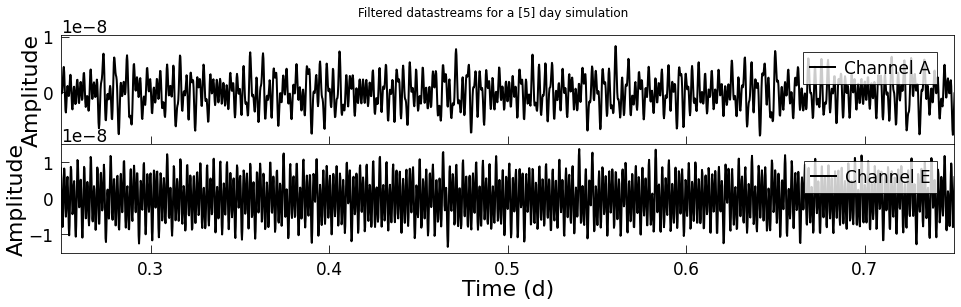

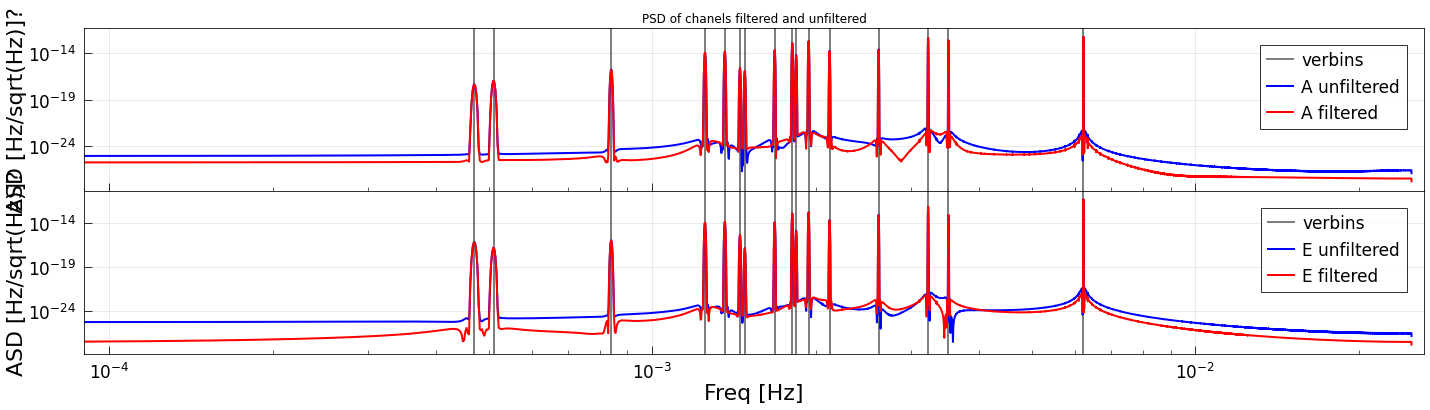

In [4]:
# Create psd for filtered data
tmp = []
for i in range(1,3):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1]])

gen_plots = True
if gen_plots:
    fig, axs = plt.subplots(2, figsize=(16,4), sharex=True, gridspec_kw={'hspace':0})
    fig.suptitle("Filtered datastreams for a "+str(duration//day)+" day simulation")
    for i in range(2):
        axs[i].plot(fsdata[0]/day,fsdata[i+1],label='Channel '+rec[i])
        axs[i].legend(loc=1)
        axs[i].set_ylabel('Amplitude')
    axs[i].set_xlabel('Time (d)')
    axs[i].set_xlim(.25,.75)
    plt.savefig('plots/Sample_filteredAETdata.jpg')

    fig, axs = plt.subplots(2, figsize=(24,6), sharex=True, gridspec_kw={'hspace':0})
    for i in range(2):
        for f in f_true:
            if f == f_true[0]:
                axs[i].plot([f]*2,[1e-50,1e50],c='black',alpha=0.5,label="verbins")
            else:
                axs[i].plot([f]*2,[1e-50,1e50],c='black',alpha=0.5)
        axs[i].plot(psd[0],psd[i+1], label=rec[i]+' unfiltered',c='blue')
        axs[i].plot(fpsd[0],fpsd[i+1], label=rec[i]+' filtered',c='red')
        axs[i].legend()
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Freq [Hz]')
        axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
        axs[i].set_ylim(ymin=0.1*np.min(fpsd[i+1]),ymax=10*np.max(psd[i+1]))
        # axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
        axs[i].grid()
    axs[0].set_title("PSD of chanels filtered and unfiltered")
    axs[i].set_xlim(xmin=9e-5,xmax=fs/1.9)#,xmax=1e-2)
    # plt.savefig("plots/Sample_PSD.jpg")

In [5]:
# Build TDI Chanels
Afunc, Efunc = BuildModelTDI(orbit_path,fs,size[d]+600,Amp_true, f_true, phi0_true, gw_beta_true,
                             gw_lambda_true,discard,detailed=True,interpolate=False)

Start model TDI building
For model data: gw_gen = 0.09 s, signal_gen = 0.03 s, TDIbuild = 17.44 s, TDIcalc = 1.18 s, Total = 18.74 s


In [6]:


def dphi_to_dnu_gradient(fs,data):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt=1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.gradient(data) * ((laser_freq) / (2*np.pi*dt))

def fit_model(st,a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15):
# def fit_model(st,a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15,\
#                  p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15):
    
    Amp_guess = np.array([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15])
    # phi0_guess = np.array([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15])
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    for a, f, p, beta, lamb, i in zip(Amp_guess, f_true, phi0_true, gw_beta_true, gw_lambda_true, iota_true):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs,iota=i\
                                ,size=size[d]+900)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
        GalBin.write(gwfn)
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=False)
    mA = Afunc(rawdata.measurements)[discard:]
    # mE = Efunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    # co2 = 20
    # nmt = np.copy(mt)[co2:-co2]
    # nmA = dphi_to_dnu_gradient(fs,mA)[co2:-co2]
    # nmE = dphi_to_dnu_gradient(fs,mE)[co2:-co2]
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    # nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    # nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]
    
    return nnmA
    # return np.array([nnmt,nnmA])
    # return np.array([nnmt,nnmA,nnmE])

def fit_model2(st,a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15):
# def fit_model(st,a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15,\
#                  p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15):
    
    Amp_guess = np.array([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15])
    # phi0_guess = np.array([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15])
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    for a, f, p, beta, lamb, i in zip(Amp_guess, f_true, phi0_true, gw_beta_true, gw_lambda_true, iota_true):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs,iota=i\
                                ,size=size[d]+900)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
        GalBin.write(gwfn)
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=False)
    mA = Afunc(rawdata.measurements)[discard:]
    # mE = Efunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    # co2 = 20
    # nmt = np.copy(mt)[co2:-co2]
    # nmA = dphi_to_dnu_gradient(fs,mA)[co2:-co2]
    # nmE = dphi_to_dnu_gradient(fs,mE)[co2:-co2]
    
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    # nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    # nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]
    
    # return nnmA
    return np.array([nnmt,nnmA])
    # return np.array([nnmt,nnmA,nnmE])

In [7]:
# mdata_gr = fit_model(fsdata[0][1:],*Amp_true,True)
mdata_s = fit_model2(sdata[0][1:],*Amp_true)
mdata_fs = fit_model2(fsdata[0],*Amp_true)


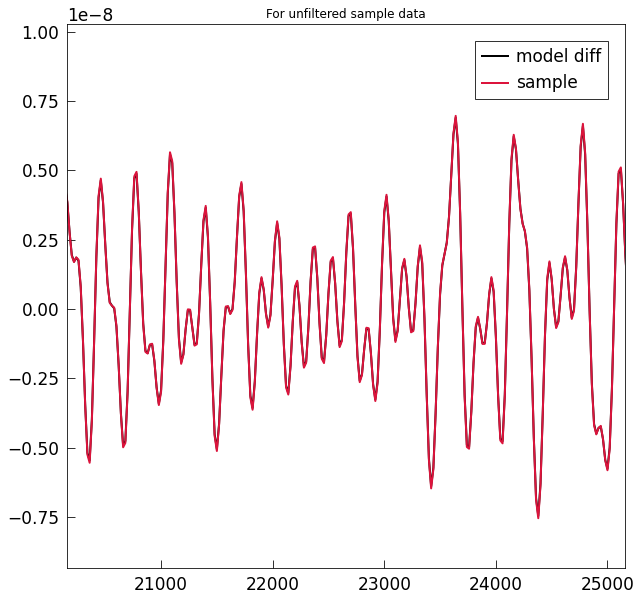

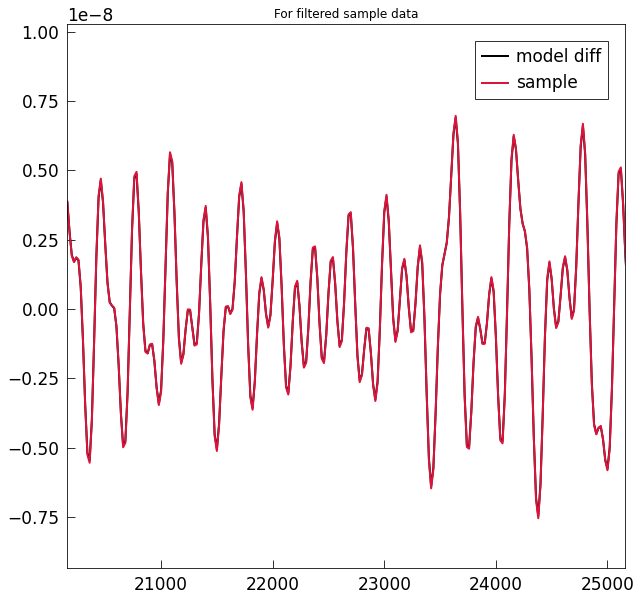

In [8]:
# print (sdata[0])
# print (fsdata[0])
# # print (mdata_gr[0])
# print (mdata_df[0])

plt.plot(mdata_s[0],mdata_s[1],label="model diff")
plt.plot(sdata[0],sdata[1],label="sample")
# plt.plot(sdata[0][1:],sdata[1][1:]-mdata_s[1],label="su")
plt.title("For unfiltered sample data")
plt.legend()
plt.xlim(np.array([np.min(fsdata[0][0]),np.min(fsdata[0][0])+5000]))
plt.show()
plt.plot(mdata_fs[0],mdata_fs[1],label="model diff")
plt.plot(fsdata[0],fsdata[1],label="sample")
# plt.plot(fsdata[0],fsdata[1]-mdata_fs[1],label="su")
plt.title("For filtered sample data")
plt.legend()
plt.xlim(np.array([np.min(fsdata[0][0]),np.min(fsdata[0][0])+5000]))
plt.show()

In [9]:
# Amp_atrue = np.zeros(Ngalbins)

# Fit fsdata to check
Amp_atrue, pcov = curve_fit(fit_model, fsdata[0],fsdata[1],p0=Amp_true)
# Amp_atrue, pcov = curve_fit(fit_model, fsdata[0],fsdata[1],p0=[*Amp_true,*phi0_true])


In [10]:
print (sdata.shape)
print (sdata[0])

(3, 21300)
[ 18160.  18180.  18200. ... 444100. 444120. 444140.]


In [11]:

# Fit sdata to check if due to filtering
Amp_atrue2, pcov2 = curve_fit(fit_model, sdata[0][11:],sdata[1][11:],p0=Amp_true)
# Amp_atrue2, pcov2 = curve_fit(fit_model, sdata[0][1:],sdata[1][1:],p0=[*Amp_true,*phi0_true])


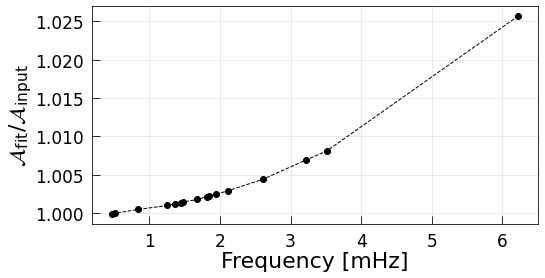

In [14]:
# tmp = [*Amp_true,*phi0_true]
# for mi,ma,title in zip([0,Ngalbins],[Ngalbins,2*Ngalbins],["Amplitude",'Phase0']):
#     print (mi,ma)
#     plt.scatter(f_true,Amp_atrue[mi:ma]/tmp[mi:ma]*100-100,label="filtered sample");

#     plt.scatter(f_true,Amp_atrue2[mi:ma]/tmp[mi:ma]*100-100,label="sample")
#     plt.xlabel("Freq [Hz]")
#     plt.ylabel("fit/input [%]")
#     plt.title(title)
#     plt.legend()
#     plt.show()
sort = np.argsort(f_true)

plt.figure(figsize=(8,4))
plt.plot(f_true[sort]*1e3,(Amp_atrue/Amp_true)[sort],marker='o',linestyle='--',linewidth=1);

# plt.scatter(f_true*1e3,Amp_atrue2/Amp_true*100,label="sample")
plt.xlabel("Frequency [mHz]")
plt.ylabel("$\mathcal{A}_\mathrm{fit}/\mathcal{A}_\mathrm{input}$")
# plt.legend(loc=2)
plt.grid()
plt.savefig("plots/wrong_amplitude.pdf")
plt.show()


In [13]:
tmp = np.min(sdata[0]/day) + np.linspace(0,0.2,2)

nmdata = fit_model2(sdata[0][1:],*Amp_atrue2)
nmdata2 = fit_model2(sdata[0][1:],*Amp_true,*phi0_true)
print (sdata.shape,nmdata.shape)
i=0
for mi,ma in zip(tmp[:-1],tmp[1:]):
    # avg = (sdata[i+1][1:]+sdata[i+1][:-1])/2
    plt.figure(figsize=(16,6))
    plt.plot(sdata[0]/day,sdata[i+1],label="instrument")
    plt.plot(nmdata[0]/day,nmdata[i+1],label="gws")
    # plt.plot((nmdata2[0]/day),(nmdata2[i+1])-sdata[i+1][1:],label="substracted input")
    plt.plot((nmdata[0]/day),(nmdata[i+1])-sdata[i+1][1:],label="substracted opt")
    plt.title(rec[i]+' datastreams for '+str(duration/day)+'d simulation with all noises')
    plt.legend()
    plt.xlabel('Time (hrs)')
    plt.ylabel('Amplitude')
    plt.xlim(mi,ma)
    plt.show()

TypeError: fit_model2() takes 17 positional arguments but 33 were given

## Test if amplitude problem is Windowing issue

In [ ]:
def fit_model3(st,a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15):#,\
#                 p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, ):
    
    Amp_guess = np.array([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15])
#    phi0_guess = np.array([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15])
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    for a, f, p, beta, lamb in zip(Amp_guess, f_true, phi0_true, gw_beta_true, gw_lambda_true):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs,\
                                size=size[d]+900)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
        GalBin.write(gwfn)
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=False)
    mA = Afunc(rawdata.measurements)[discard:]
    # mE = Efunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    # co2 = 20
    # nmt = np.copy(mt)[co2:-co2]
    # nmA = dphi_to_dnu_gradient(fs,mA)[co2:-co2]
    # nmE = dphi_to_dnu_gradient(fs,mE)[co2:-co2]
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    # nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    # nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]
    
    return nnmA*Hanning(len(nnmA))

# Define the Hanning window for sample and model data
Ndatapoints = len(fsdata[0])
def Hanning(N):
    j = np.arange(N,dtype=float)
    return 0.5*(1 - np.cos((2*np.pi*j)/(N)))

plt.plot(fsdata[0]/day,Hanning(Ndatapoints))
plt.title("Hanning window")
plt.show()
plt.plot(fsdata[0]/day,fsdata[1]*Hanning(Ndatapoints))
plt.title("Hanning window applied to data")
plt.show()

In [ ]:
Amp_atrue3, pcov3 = curve_fit(fit_model3, fsdata[0],Hanning(Ndatapoints)*fsdata[1],p0=Amp_true)

In [ ]:

plt.scatter(f_true,Amp_atrue[:16]/Amp_true*100,label="Normal sample")
plt.scatter(f_true,Amp_atrue3/Amp_true*100,label="Windowed sample")
plt.xlabel("Freq [Hz]")
plt.ylabel("fit/input [%]")
plt.title("Amp offset vs frequency for Hanning window")
plt.legend()
plt.show()

## Test if amplitude problem can be solved by just using instrument and not from_gws

In [ ]:
def indiv_mdata(st,Afunc,Efunc,s,a, f, p, beta, lamb, t0=orbits_t0+1/fs):
    # Create random filename to allow for multiprocessing

    gwfn = ext2+'gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=s+600)
    GalBin.write(gwfn)
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=False)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    
    return np.array([nnmt,nnmA,nnmE])

In [ ]:
#def GenerateInstrumentAET(orbit_path, gw_path, fs, size, sample_outputf, discard, genTDI=True, sAfunc = False, sEfunc = False, tm_alpha=1,noise=True):
drrnge = [1,2,5,10]
time_tracking = np.zeros((2,len(drrnge)))
a, f, p, beta, lamb = np.array([Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true])[:,0]

coeffs = scipy.signal.firls(73, bands=[0,1e-2,1.5e-2,fs/2], desired=[1,1,0,0],fs=fs)
cutoff = 100

for d,dr in enumerate(drrnge):
    s = dr*fs*day
    
    outputf = 'gws_spam/testdata0'

    GenerateGalbins(orbit_path,gw_path,fs,s,[a], [f], [0], [beta], [lamb], orbits_t0 + 1/fs)
    sAfunc, sEfunc = GenerateInstrumentAET(orbit_path, gw_path, fs, s, outputf, discard, True, noise=False)
    rawdata = ascii.read(outputf+'.txt')
    # sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])
    sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])
    tmp = []
    for i in range(1,3):
        ftmp, psdtmp = psd_func(sdata[i])
        tmp.append(psdtmp)
    psd = np.array([ftmp,tmp[0],tmp[1]])

    
    
    time00 = time.time()
    
    outputf = 'gws_spam/testdata1'
    gw_path = 'gws_spam/tmp_gws.h5'
    
    GenerateGalbins(orbit_path,gw_path,fs,s,[a], [f], [0], [beta], [lamb], orbits_t0 + 1/fs)
    GenerateInstrumentAET(orbit_path, gw_path, fs, s, outputf, discard, False, sAfunc, sEfunc,noise=False)
    # os.remove(outputf+'.h5')
    # Retreive A, E, T data
    rawdata = ascii.read(outputf+'.txt')
    # sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])
    sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])

    # Filter sample data
    tmp = []
    for k in range(1,3):
        fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[k],padlen=len(psd[0]))
        tmp.append(fdata_tmp[cutoff:-cutoff])
    fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1]])

    time_tracking[0,d] = time.time()-time00
    
    
    # Now for model data
    Afunc, Efunc = BuildModelTDI(orbit_path,fs,s+300,[a], [f], [p], [beta], [lamb],discard,detailed=True,interpolate=False)

    
    time01 = time.time()
    
    model = indiv_mdata(fsdata[0],Afunc,Efunc,s,a, f, p, beta, lamb)
    
    time_tracking[1,d] = time.time()-time01



In [ ]:
plt.figure(figsize=(16,4))
plt.plot(fsdata[0]/day,fsdata[1],label="From instrument")
plt.plot(model[0]/day,model[1],label="From gws")
plt.xlim(1,1.05)
plt.legend()
plt.show()

In [ ]:

plt.plot(drrnge,time_tracking[0],label="Instrument",marker='o',linestyle='--')
plt.plot(drrnge,time_tracking[1],label="gws",marker='o',linestyle='--')
plt.xlabel("Simulation duration [days]")
plt.ylabel("Time to run simulation [s]")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
from astropy.io import ascii

fp = 'measurements/tm_asds/5d/'
print (len(ascii.read(fp+'1/fs0.txt')['t']))
print (len(ascii.read(fp+'mdata/binary_0.txt')['t']))


In [ ]:
print 